In [1]:
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
import xgboost
from sklearn import preprocessing, linear_model, ensemble, metrics
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

In [3]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers, models, optimizers
from keras.layers import LSTM
from keras.layers.merge import concatenate
from keras.utils import to_categorical
from keras.utils import np_utils

Using TensorFlow backend.


# 准备文本

## abstract

In [4]:
abs_filepath = "/home/hxjiang/Pythonworkspace/patent/sample3_G-06-F-17/textual/result/abstract/8/AbsModel-ep003-loss0.618-val_loss0.613.h5.xlsx"
abstract = pd.read_excel(abs_filepath, encoding='utf-8')

In [5]:
abstract.shape

(7769, 72)

In [6]:
x_abs = abstract
# 条件数在1附近是理想的，有文献表明超过15就说明存在共线性
c = np.linalg.cond(x_abs, p=None)
c

/home/hxjiang/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py:1543: RuntimeWarning: divide by zero encountered in true_divide
  return s[..., 0]/s[..., -1]


inf

## claims

In [26]:
claim_filepath = "/home/hxjiang/Pythonworkspace/patent/sample3_G-06-F-17/textual/result/claims/2/2ClaimsModel-ep003-loss0.615-val_loss0.613.h5.xlsx"
claims = pd.read_excel(claim_filepath, encoding='utf-8')

In [27]:
claims.shape

(7769, 72)

In [28]:
x_claims = claims
# 条件数在1附近是理想的，有文献表明超过15就说明存在共线性
c = np.linalg.cond(x_claims, p=None)
c

/home/hxjiang/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py:1543: RuntimeWarning: divide by zero encountered in true_divide
  return s[..., 0]/s[..., -1]


inf

## text_sum

In [29]:
sum_feature = pd.concat([abstract,claims],  axis=1, ignore_index=True)

In [30]:
text_filepath = "/home/hxjiang/Pythonworkspace/patent/sample3_G-06-F-17/textual/result/fusion/11/11FusionModel-ep003-loss0.610-val_loss0.607.h5.xlsx"
sum_feature = pd.read_excel(text_filepath, encoding='utf-8')

In [31]:
sum_feature.shape

(7769, 72)

In [32]:
x_text = sum_feature
# 条件数在1附近是理想的，有文献表明超过15就说明存在共线性
c = np.linalg.cond(x_text, p=None)
c

inf

## result

In [7]:
data = pd.read_excel("/home/hxjiang/Pythonworkspace/patent/sample3_G-06-F-17/textual/result_2010.xlsx", encoding='utf-8')

In [8]:
result = data['result']

In [9]:
train_target = np_utils.to_categorical(data[['result']], 2)
y_ints = [y.argmax() for y in train_target]
cw = class_weight.compute_class_weight('balanced', np.unique(y_ints), y_ints)
cw

array([1.49346405, 0.75164474])

In [10]:
train_target.shape

(7769, 2)

## node

In [398]:
node_file = "/home/hxjiang/Pythonworkspace/patent/sample3_G-06-F-17/ActiveHNE/data/0-3.xlsx"
node = pd.read_excel(node_file, encoding='utf-8', header=None)

In [399]:
node.shape

(7769, 72)

In [400]:
# 条件数在1附近是理想的，有文献表明超过15就说明存在共线性
c = np.linalg.cond(node, p=None)
c

363.7637858159597

In [401]:
node = node/100

## node_text

In [402]:
node_text = pd.concat([sum_feature, node],  axis=1, ignore_index=True)
node_text.shape

(7769, 144)

In [403]:
node_text_c = np.linalg.cond(node_text, p=None)
print("node_text= {:.4f}".format(node_text_c))

node_text= inf


/home/hxjiang/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py:1543: RuntimeWarning: divide by zero encountered in true_divide
  return s[..., 0]/s[..., -1]


## 归一化or标准化处理

In [23]:
x_abs = preprocessing.scale(x_abs)
# node_text = preprocessing.minmax_scale(node_text)

In [24]:
x_claims = preprocessing.scale(x_claims)
# node_text = preprocessing.minmax_scale(node_text)

In [248]:
x_text = preprocessing.scale(x_text)
# node_text = preprocessing.minmax_scale(node_text)

In [349]:
node = preprocessing.scale(node)
# node_text = preprocessing.minmax_scale(node_text)

In [293]:
node_text = preprocessing.scale(node_text)
# node_text = preprocessing.minmax_scale(node_text)

# 划分训练集

In [11]:
x_abs_train = x_abs[:6215]
x_abs_valid = x_abs[6215:6992]
x_abs_test = x_abs[6992:]

In [33]:
x_claims_train = x_claims[:6215]
x_claims_valid = x_claims[6215:6992]
x_claims_test = x_claims[6992:]

In [34]:
x_text_train = x_text[:6215]
x_text_valid = x_text[6215:6992]
x_text_test = x_text[6992:]

In [404]:
x_node_train = node[:6215]
x_node_valid = node[6215:6992]
x_node_test = node[6992:]

In [405]:
node_text_train = node_text[:6215]
node_text_valid = node_text[6215:6992]
node_text_test = node_text[6992:]

In [12]:
y_binary_train = result[:6215]
y_binary_valid = result[6215:6992]
y_binary_test = result[6992:]

y_category_train = train_target[:6215]
y_category_valid = train_target[6215:6992]
y_category_test = train_target[6992:]

In [13]:
sum(y_category_train[:,1])/sum(y_category_train[:,0])

1.9765325670498084

# 机器学习分类

In [35]:
def train_model(classifier, x_train, y_train, x_test, y_test):
    classifier.fit(x_train, y_train)
    
    y_predict = classifier.predict(x_test)# 每一个x的预测值
    y_predict_proba = classifier.predict_proba(x_test) # 预测分类的概率
    
    precision = metrics.precision_score(y_test, y_predict) # 精确率
    recall = metrics.recall_score(y_test, y_predict) # 召回率
    f1 = metrics.f1_score(y_test, y_predict) # f1
    accuracy = metrics.accuracy_score(y_test, y_predict, normalize = True) # 准确率
    
    # print("accuracy: {:.4f} precision: {:.4f} recall: {:.4f} f1: {:.4f}".format(accuracy,precision,recall,f1))
    
    return y_predict,y_predict_proba

## abstract

In [573]:
def marchine_learn(x_train, y_train, x_test, y_test):
    classifier_list = [linear_model.LogisticRegression(random_state=0, penalty='l2', class_weight="balanced", C=0.005, fit_intercept=True),
                       ensemble.RandomForestClassifier(random_state=0, class_weight="balanced", n_estimators=10), 
                       xgboost.XGBClassifier(random_state=0, scale_pos_weight=0.75/1.49, learning_rate=0.15, n_estimators=400)]

    y_predict_proba_dic = {}
    y_predict_list = []
    for i, classifier in enumerate(tqdm(classifier_list, ncols=50)):
        y_predict, y_predict_proba = train_model(
            classifier, x_train, y_train, x_test, y_test)
        # print("predictions:", y_predict)
        y_predict_proba_dic[i] = y_predict_proba
        y_predict_list.append(y_predict)

    return y_predict_list, y_predict_proba_dic

In [574]:
iter_dic = {}
for i in range(1):
    y_predict_list, y_predict_proba_dic = marchine_learn(x_abs_train, y_binary_train, x_abs_test, y_binary_test)
    iter_dic[i] = y_predict_list

100%|███████████████| 3/3 [00:07<00:00,  2.36s/it]


In [575]:
LR_metrics_list = []
RF_metrics_list = []
XGB_metrics_list = []

for key, value in iter_dic.items():
    for i in range(3):
        report = classification_report(y_binary_test, iter_dic[key][i], digits=4)
        p = re.compile('  |\n', re.S)
        report = p.sub(' ', report)
        metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
        if i == 0:
            LR_metrics_list.append(metrics_content)
        if i == 1:
            RF_metrics_list.append(metrics_content)
        if i == 2:
            XGB_metrics_list.append(metrics_content)

In [576]:
# LR
LR_metrics_arrat = np.array(LR_metrics_list, dtype=float)
acc = np.mean(LR_metrics_arrat[:, 0])
print("LR acc:  {:.4f}".format(acc))
f1 = np.mean(LR_metrics_arrat[:, 1])
print("LR macro:  {:.4f}".format(f1))
weighted = np.mean(LR_metrics_arrat[:, 2])
print("LR weighted:  {:.4f}".format(weighted))

print(LR_metrics_arrat[:, 0].tolist())
print(LR_metrics_arrat[:, 1].tolist())
print(LR_metrics_arrat[:, 2].tolist())

LR acc:  0.5972
LR macro:  0.5840
LR weighted:  0.6077
[0.5972]
[0.584]
[0.6077]


In [577]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.4347    0.6174    0.5102       264
           1     0.7488    0.5867    0.6579       513

    accuracy                         0.5972       777
   macro avg     0.5917    0.6021    0.5840       777
weighted avg     0.6420    0.5972    0.6077       777



In [578]:
# RF
RF_metrics_arrat = np.array(RF_metrics_list,dtype=float)
acc = np.mean(RF_metrics_arrat[:,0])
print("RF acc:  {:.4f}".format(acc))
f1 = np.mean(RF_metrics_arrat[:,1])
print("RF macro:  {:.4f}".format(f1))
weighted = np.mean(RF_metrics_arrat[:,2])
print("RF weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

RF acc:  0.6422
RF macro:  0.5760
RF weighted:  0.6297
[0.6422]
[0.576]
[0.6297]


In [579]:
print(classification_report(y_binary_test, iter_dic[0][1], digits=4))

              precision    recall  f1-score   support

           0     0.4660    0.3636    0.4085       264
           1     0.7058    0.7856    0.7435       513

    accuracy                         0.6422       777
   macro avg     0.5859    0.5746    0.5760       777
weighted avg     0.6243    0.6422    0.6297       777



In [580]:
# XGB
XGB_metrics_arrat = np.array(XGB_metrics_list,dtype=float)
acc = np.mean(XGB_metrics_arrat[:,0])
print("XGB acc:  {:.4f}".format(acc))
f1 = np.mean(XGB_metrics_arrat[:,1])
print("XGB macro:  {:.4f}".format(f1))
weighted = np.mean(XGB_metrics_arrat[:,2])
print("XGB weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

XGB acc:  0.6152
XGB macro:  0.5614
XGB weighted:  0.6106
[0.6422]
[0.576]
[0.6297]


In [581]:
print(classification_report(y_binary_test, iter_dic[0][2], digits=4))

              precision    recall  f1-score   support

           0     0.4274    0.3902    0.4079       264
           1     0.6996    0.7310    0.7150       513

    accuracy                         0.6152       777
   macro avg     0.5635    0.5606    0.5614       777
weighted avg     0.6071    0.6152    0.6106       777



## claims

In [758]:
def marchine_learn(x_train, y_train, x_test, y_test):
    classifier_list = [linear_model.LogisticRegression(random_state=0, penalty='l2', class_weight="balanced", C=0.005, fit_intercept=False),
                       ensemble.RandomForestClassifier(random_state=0, class_weight="balanced", n_estimators=10), 
                       xgboost.XGBClassifier(random_state=0, scale_pos_weight=0.75/1.49, learning_rate=0.15, n_estimators=300)]

    y_predict_proba_dic = {}
    y_predict_list = []
    for i, classifier in enumerate(tqdm(classifier_list, ncols=50)):
        y_predict, y_predict_proba = train_model(
            classifier, x_train, y_train, x_test, y_test)
        # print("predictions:", y_predict)
        y_predict_proba_dic[i] = y_predict_proba
        y_predict_list.append(y_predict)

    return y_predict_list, y_predict_proba_dic

In [759]:
iter_dic = {}
for i in range(1):
    y_predict_list, y_predict_proba_dic = marchine_learn(x_claims_train, y_binary_train, x_claims_test, y_binary_test)
    iter_dic[i] = y_predict_list

100%|███████████████| 3/3 [00:12<00:00,  4.08s/it]


In [760]:
LR_metrics_list = []
RF_metrics_list = []
XGB_metrics_list = []

for key, value in iter_dic.items():
    for i in range(3):
        report = classification_report(y_binary_test, iter_dic[key][i], digits=4)
        p = re.compile('  |\n', re.S)
        report = p.sub(' ', report)
        metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
        if i == 0:
            LR_metrics_list.append(metrics_content)
        if i == 1:
            RF_metrics_list.append(metrics_content)
        if i == 2:
            XGB_metrics_list.append(metrics_content)

In [586]:
# LR
LR_metrics_arrat = np.array(LR_metrics_list,dtype=float)
acc = np.mean(LR_metrics_arrat[:,0])
print("LR acc:  {:.4f}".format(acc))
f1 = np.mean(LR_metrics_arrat[:,1])
print("LR macro:  {:.4f}".format(f1))
weighted = np.mean(LR_metrics_arrat[:,2])
print("LR weighted:  {:.4f}".format(weighted))

print(LR_metrics_arrat[:,0].tolist())
print(LR_metrics_arrat[:,1].tolist())
print(LR_metrics_arrat[:,2].tolist())

LR acc:  0.6306
LR macro:  0.5917
LR weighted:  0.6321
[0.6306]
[0.5917]
[0.6321]


In [587]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.4579    0.4735    0.4655       264
           1     0.7242    0.7115    0.7178       513

    accuracy                         0.6306       777
   macro avg     0.5910    0.5925    0.5917       777
weighted avg     0.6337    0.6306    0.6321       777



In [588]:
# RF
RF_metrics_arrat = np.array(RF_metrics_list,dtype=float)
acc = np.mean(RF_metrics_arrat[:,0])
print("RF acc:  {:.4f}".format(acc))
f1 = np.mean(RF_metrics_arrat[:,1])
print("RF macro:  {:.4f}".format(f1))
weighted = np.mean(RF_metrics_arrat[:,2])
print("RF weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

RF acc:  0.6268
RF macro:  0.5639
RF weighted:  0.6170
[0.6268]
[0.5639]
[0.617]


In [589]:
print(classification_report(y_binary_test, iter_dic[0][1], digits=4))

              precision    recall  f1-score   support

           0     0.4404    0.3636    0.3983       264
           1     0.6995    0.7622    0.7295       513

    accuracy                         0.6268       777
   macro avg     0.5699    0.5629    0.5639       777
weighted avg     0.6114    0.6268    0.6170       777



In [761]:
# XGB
XGB_metrics_arrat = np.array(XGB_metrics_list,dtype=float)
acc = np.mean(XGB_metrics_arrat[:,0])
print("XGB acc:  {:.4f}".format(acc))
f1 = np.mean(XGB_metrics_arrat[:,1])
print("XGB macro:  {:.4f}".format(f1))
weighted = np.mean(XGB_metrics_arrat[:,2])
print("XGB weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

XGB acc:  0.6036
XGB macro:  0.5701
XGB weighted:  0.6085
[0.6873]
[0.593]
[0.6557]


In [762]:
print(classification_report(y_binary_test, iter_dic[0][2], digits=4))

              precision    recall  f1-score   support

           0     0.4257    0.4773    0.4500       264
           1     0.7131    0.6686    0.6901       513

    accuracy                         0.6036       777
   macro avg     0.5694    0.5729    0.5701       777
weighted avg     0.6154    0.6036    0.6085       777



## text_sum

In [747]:
def marchine_learn(x_train, y_train, x_test, y_test):
    classifier_list = [linear_model.LogisticRegression(random_state=0, penalty='l2', class_weight="balanced", C=0.01, fit_intercept=False),
                       ensemble.RandomForestClassifier(random_state=0, class_weight="balanced", n_estimators=140), 
                       xgboost.XGBClassifier(random_state=0, scale_pos_weight=0.75/1.49, learning_rate=0.1, n_estimators=300)]

    y_predict_proba_dic = {}
    y_predict_list = []
    for i, classifier in enumerate(tqdm(classifier_list, ncols=50)):
        y_predict, y_predict_proba = train_model(
            classifier, x_train, y_train, x_test, y_test)
        # print("predictions:", y_predict)
        y_predict_proba_dic[i] = y_predict_proba
        y_predict_list.append(y_predict)

    return y_predict_list, y_predict_proba_dic

In [748]:
iter_dic = {}
for i in range(1):
    y_predict_list, y_predict_proba_dic = marchine_learn(x_text_train, y_binary_train, x_text_test, y_binary_test)
    iter_dic[i] = y_predict_list

100%|███████████████| 3/3 [00:09<00:00,  3.27s/it]


In [749]:
LR_metrics_list = []
RF_metrics_list = []
XGB_metrics_list = []

for key, value in iter_dic.items():
    for i in range(3):
        report = classification_report(y_binary_test, iter_dic[key][i], digits=4)
        p = re.compile('  |\n', re.S)
        report = p.sub(' ', report)
        metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
        if i == 0:
            LR_metrics_list.append(metrics_content)
        if i == 1:
            RF_metrics_list.append(metrics_content)
        if i == 2:
            XGB_metrics_list.append(metrics_content)

In [595]:
# LR
LR_metrics_arrat = np.array(LR_metrics_list,dtype=float)
acc = np.mean(LR_metrics_arrat[:,0])
print("LR acc:  {:.4f}".format(acc))
f1 = np.mean(LR_metrics_arrat[:,1])
print("LR macro:  {:.4f}".format(f1))
weighted = np.mean(LR_metrics_arrat[:,2])
print("LR weighted:  {:.4f}".format(weighted))

print(LR_metrics_arrat[:,0].tolist())
print(LR_metrics_arrat[:,1].tolist())
print(LR_metrics_arrat[:,2].tolist())

LR acc:  0.6332
LR macro:  0.6019
LR weighted:  0.6377
[0.6332]
[0.6019]
[0.6377]


In [596]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.4644    0.5189    0.4902       264
           1     0.7365    0.6920    0.7136       513

    accuracy                         0.6332       777
   macro avg     0.6005    0.6055    0.6019       777
weighted avg     0.6441    0.6332    0.6377       777



In [736]:
# RF
RF_metrics_arrat = np.array(RF_metrics_list,dtype=float)
acc = np.mean(RF_metrics_arrat[:,0])
print("RF acc:  {:.4f}".format(acc))
f1 = np.mean(RF_metrics_arrat[:,1])
print("RF macro:  {:.4f}".format(f1))
weighted = np.mean(RF_metrics_arrat[:,2])
print("RF weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

RF acc:  0.6873
RF macro:  0.5930
RF weighted:  0.6557
[0.6873]
[0.593]
[0.6557]


In [737]:
print(classification_report(y_binary_test, iter_dic[0][1], digits=4))

              precision    recall  f1-score   support

           0     0.5755    0.3030    0.3970       264
           1     0.7116    0.8850    0.7889       513

    accuracy                         0.6873       777
   macro avg     0.6436    0.5940    0.5930       777
weighted avg     0.6654    0.6873    0.6557       777



In [750]:
# XGB
XGB_metrics_arrat = np.array(XGB_metrics_list,dtype=float)
acc = np.mean(XGB_metrics_arrat[:,0])
print("XGB acc:  {:.4f}".format(acc))
f1 = np.mean(XGB_metrics_arrat[:,1])
print("XGB macro:  {:.4f}".format(f1))
weighted = np.mean(XGB_metrics_arrat[:,2])
print("XGB weighted:  {:.4f}".format(weighted))

print(XGB_metrics_arrat[:,0].tolist())
print(XGB_metrics_arrat[:,1].tolist())
print(XGB_metrics_arrat[:,2].tolist())

XGB acc:  0.6461
XGB macro:  0.5975
XGB weighted:  0.6423
[0.6461]
[0.5975]
[0.6423]


In [751]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.4644    0.5189    0.4902       264
           1     0.7365    0.6920    0.7136       513

    accuracy                         0.6332       777
   macro avg     0.6005    0.6055    0.6019       777
weighted avg     0.6441    0.6332    0.6377       777



## node

In [780]:
def marchine_learn(x_train, y_train, x_test, y_test):
    classifier_list = [linear_model.LogisticRegression(random_state=0, penalty='l2', max_iter=1300, class_weight="balanced", C=0.5, fit_intercept=True),
                       ensemble.RandomForestClassifier(random_state=0, class_weight="balanced", n_estimators=10), 
                       xgboost.XGBClassifier(random_state=0, scale_pos_weight=0.75/1.49, learning_rate=0.15, n_estimators=400)]

    y_predict_proba_dic = {}
    y_predict_list = []
    for i, classifier in enumerate(tqdm(classifier_list, ncols=50)):
        y_predict, y_predict_proba = train_model(
            classifier, x_train, y_train, x_test, y_test)
        # print("predictions:", y_predict)
        y_predict_proba_dic[i] = y_predict_proba
        y_predict_list.append(y_predict)

    return y_predict_list, y_predict_proba_dic

In [781]:
iter_dic = {}
for i in range(1):
    y_predict_list, y_predict_proba_dic = marchine_learn(x_node_train, y_binary_train, x_node_test, y_binary_test)
    iter_dic[i] = y_predict_list

100%|███████████████| 3/3 [00:28<00:00,  9.46s/it]


In [782]:
LR_metrics_list = []
RF_metrics_list = []
XGB_metrics_list = []

for key, value in iter_dic.items():
    for i in range(3):
        report = classification_report(y_binary_test, iter_dic[key][i], digits=4)
        p = re.compile('  |\n', re.S)
        report = p.sub(' ', report)
        metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
        if i == 0:
            LR_metrics_list.append(metrics_content)
        if i == 1:
            RF_metrics_list.append(metrics_content)
        if i == 2:
            XGB_metrics_list.append(metrics_content)

In [722]:
# LR
LR_metrics_arrat = np.array(LR_metrics_list,dtype=float)
acc = np.mean(LR_metrics_arrat[:,0])
print("LR acc:  {:.4f}".format(acc))
f1 = np.mean(LR_metrics_arrat[:,1])
print("LR macro:  {:.4f}".format(f1))
weighted = np.mean(LR_metrics_arrat[:,2])
print("LR weighted:  {:.4f}".format(weighted))

print(LR_metrics_arrat[:,0].tolist())
print(LR_metrics_arrat[:,1].tolist())
print(LR_metrics_arrat[:,2].tolist())

LR acc:  0.7066
LR macro:  0.7025
LR weighted:  0.7136
[0.7066]
[0.7025]
[0.7136]


In [723]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.5427    0.8674    0.6676       264
           1     0.9014    0.6238    0.7373       513

    accuracy                         0.7066       777
   macro avg     0.7220    0.7456    0.7025       777
weighted avg     0.7795    0.7066    0.7136       777



In [724]:
# RF
RF_metrics_arrat = np.array(RF_metrics_list,dtype=float)
acc = np.mean(RF_metrics_arrat[:,0])
print("RF acc:  {:.4f}".format(acc))
f1 = np.mean(RF_metrics_arrat[:,1])
print("RF macro:  {:.4f}".format(f1))
weighted = np.mean(RF_metrics_arrat[:,2])
print("RF weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

RF acc:  0.7516
RF macro:  0.7197
RF weighted:  0.7500
[0.7516]
[0.7197]
[0.75]


In [725]:
print(classification_report(y_binary_test, iter_dic[0][1], digits=4))

              precision    recall  f1-score   support

           0     0.6414    0.6098    0.6252       264
           1     0.8042    0.8246    0.8142       513

    accuracy                         0.7516       777
   macro avg     0.7228    0.7172    0.7197       777
weighted avg     0.7489    0.7516    0.7500       777



In [783]:
# XGB
XGB_metrics_arrat = np.array(XGB_metrics_list,dtype=float)
acc = np.mean(XGB_metrics_arrat[:,0])
print("XGB acc:  {:.4f}".format(acc))
f1 = np.mean(XGB_metrics_arrat[:,1])
print("XGB macro:  {:.4f}".format(f1))
weighted = np.mean(XGB_metrics_arrat[:,2])
print("XGB weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

XGB acc:  0.7375
XGB macro:  0.7110
XGB weighted:  0.7390
[0.6873]
[0.593]
[0.6557]


In [784]:
print(classification_report(y_binary_test, iter_dic[0][2], digits=4))

              precision    recall  f1-score   support

           0     0.6079    0.6402    0.6236       264
           1     0.8096    0.7875    0.7984       513

    accuracy                         0.7375       777
   macro avg     0.7088    0.7138    0.7110       777
weighted avg     0.7411    0.7375    0.7390       777



## node_text

In [769]:
def marchine_learn(x_train, y_train, x_test, y_test):
    classifier_list = [linear_model.LogisticRegression(random_state=0, max_iter=1500, penalty='l2', class_weight="balanced", C=1, fit_intercept=True),
                       ensemble.RandomForestClassifier(random_state=0, class_weight="balanced", n_estimators=200), 
                       xgboost.XGBClassifier(random_state=0, scale_pos_weight=0.75/1.49, learning_rate=0.1, n_estimators=300)]

    y_predict_proba_dic = {}
    y_predict_list = []
    for i, classifier in enumerate(tqdm(classifier_list, ncols=50)):
        y_predict, y_predict_proba = train_model(
            classifier, x_train, y_train, x_test, y_test)
        # print("predictions:", y_predict)
        y_predict_proba_dic[i] = y_predict_proba
        y_predict_list.append(y_predict)

    return y_predict_list, y_predict_proba_dic

In [770]:
iter_dic = {}
for i in range(1):
    y_predict_list, y_predict_proba_dic = marchine_learn(node_text_train, y_binary_train, node_text_test, y_binary_test)
    iter_dic[i] = y_predict_list

100%|███████████████| 3/3 [00:16<00:00,  5.40s/it]


In [771]:
LR_metrics_list = []
RF_metrics_list = []
XGB_metrics_list = []

for key, value in iter_dic.items():
    for i in range(3):
        report = classification_report(y_binary_test, iter_dic[key][i], digits=4)
        p = re.compile('  |\n', re.S)
        report = p.sub(' ', report)
        metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
        if i == 0:
            LR_metrics_list.append(metrics_content)
        if i == 1:
            RF_metrics_list.append(metrics_content)
        if i == 2:
            XGB_metrics_list.append(metrics_content)

In [683]:
# LR
LR_metrics_arrat = np.array(LR_metrics_list,dtype=float)
acc = np.mean(LR_metrics_arrat[:,0])
print("LR acc:  {:.4f}".format(acc))
f1 = np.mean(LR_metrics_arrat[:,1])
print("LR macro:  {:.4f}".format(f1))
weighted = np.mean(LR_metrics_arrat[:,2])
print("LR weighted:  {:.4f}".format(weighted))

print(LR_metrics_arrat[:,0].tolist())
print(LR_metrics_arrat[:,1].tolist())
print(LR_metrics_arrat[:,2].tolist())

LR acc:  0.7439
LR macro:  0.7325
LR weighted:  0.7502
[0.7439]
[0.7325]
[0.7502]


In [684]:
print(classification_report(y_binary_test, iter_dic[0][0], digits=4))

              precision    recall  f1-score   support

           0     0.5921    0.7917    0.6775       264
           1     0.8703    0.7193    0.7876       513

    accuracy                         0.7439       777
   macro avg     0.7312    0.7555    0.7325       777
weighted avg     0.7758    0.7439    0.7502       777



In [695]:
# RF
RF_metrics_arrat = np.array(RF_metrics_list,dtype=float)
acc = np.mean(RF_metrics_arrat[:,0])
print("RF acc:  {:.4f}".format(acc))
f1 = np.mean(RF_metrics_arrat[:,1])
print("RF macro:  {:.4f}".format(f1))
weighted = np.mean(RF_metrics_arrat[:,2])
print("RF weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

RF acc:  0.7761
RF macro:  0.7359
RF weighted:  0.7689
[0.7761]
[0.7359]
[0.7689]


In [696]:
print(classification_report(y_binary_test, iter_dic[0][1], digits=4))

              precision    recall  f1-score   support

           0     0.7143    0.5682    0.6329       264
           1     0.7989    0.8830    0.8389       513

    accuracy                         0.7761       777
   macro avg     0.7566    0.7256    0.7359       777
weighted avg     0.7702    0.7761    0.7689       777



In [772]:
# XGB
XGB_metrics_arrat = np.array(XGB_metrics_list,dtype=float)
acc = np.mean(XGB_metrics_arrat[:,0])
print("XGB acc:  {:.4f}".format(acc))
f1 = np.mean(XGB_metrics_arrat[:,1])
print("XGB macro:  {:.4f}".format(f1))
weighted = np.mean(XGB_metrics_arrat[:,2])
print("XGB weighted:  {:.4f}".format(weighted))

print(RF_metrics_arrat[:,0].tolist())
print(RF_metrics_arrat[:,1].tolist())
print(RF_metrics_arrat[:,2].tolist())

XGB acc:  0.7709
XGB macro:  0.7437
XGB weighted:  0.7705
[0.6873]
[0.593]
[0.6557]


In [773]:
print(classification_report(y_binary_test, iter_dic[0][2], digits=4))

              precision    recall  f1-score   support

           0     0.6654    0.6553    0.6603       264
           1     0.8240    0.8304    0.8272       513

    accuracy                         0.7709       777
   macro avg     0.7447    0.7429    0.7437       777
weighted avg     0.7701    0.7709    0.7705       777



## 绘图

100%|█| 3/3 [00:00<0


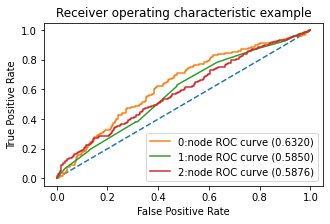

In [582]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

100%|█| 3/3 [00:00<0


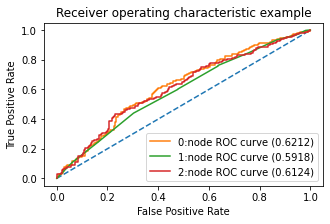

In [757]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

100%|█| 3/3 [00:00<0


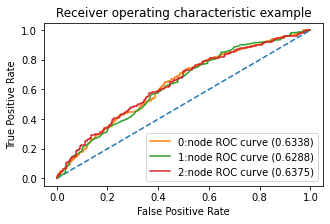

In [746]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

100%|█| 3/3 [00:00<0


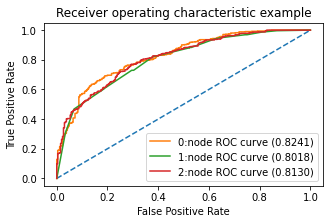

In [726]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

100%|█| 3/3 [00:00<0


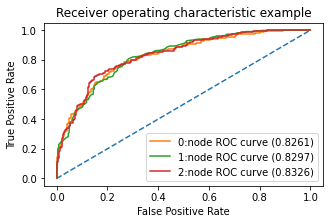

In [774]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

100%|█| 3/3 [00:00<0


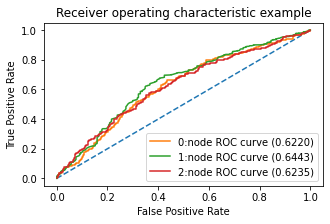

In [633]:
plt.figure(figsize=(5,3))
plt.plot([0, 1], [0, 1], linestyle='--')
for key in tqdm(y_predict_proba_dic.keys(), ncols=20):
    y_scores = [y_predict_proba_1[1] for y_predict_proba_1 in y_predict_proba_dic[key]]
    fpr, tpr, _  =  roc_curve(y_binary_test, y_scores)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label=str(key) + ':node ROC curve (%0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 神经网络分类

In [37]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [453]:
def full_connect_network(n_cols):
    # Add an Input Layer
    input_layer = layers.Input((n_cols, ))

    Dense_layer_1 = layers.Dense(152, activation="relu")(input_layer)
    Dense_layer_2 = layers.Dense(64, activation="relu")(Dense_layer_1)
    dropout_layer = layers.Dropout(0.35)(Dense_layer_2)
    Dense_layer_3 = layers.Dense(2, activation='softmax')(dropout_layer)

    model = models.Model(inputs=input_layer, outputs=Dense_layer_3)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    # model.summary()

    return model

In [406]:
def full_connect_network(n_cols):
    # Add an Input Layer
    input_layer = layers.Input((n_cols, ))

    Dense_layer_1 = layers.Dense(80, activation="relu")(input_layer)
    Dense_layer_2 = layers.Dense(48, activation="relu")(Dense_layer_1)
    dropout_layer = layers.Dropout(0.4)(Dense_layer_2)
    Dense_layer_3 = layers.Dense(2, activation='softmax')(dropout_layer)

    model = models.Model(inputs=input_layer, outputs=Dense_layer_3)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    # model.summary()

    return model

In [415]:
def full_lstm_connect_network(n_cols):
    # Add an Input Layer
    input_layer = layers.Input((n_cols, ))
    
    input_layer_1 = layers.Lambda(lambda input_layer:K.expand_dims(input_layer, axis=-1))(input_layer)
    lstm_layer = layers.Bidirectional(LSTM(128, return_sequences=False))(input_layer_1)
    Dropout_layer = layers.Dropout(0.4)(lstm_layer)
    Dense_layer_1 = layers.Dense(72, activation="relu")(Dropout_layer)
    Dropout_layer = layers.Dropout(0.4)(Dense_layer_1)
    Dense_layer_1 = layers.Dense(2, activation='softmax')(Dropout_layer)
    
    model = models.Model(inputs=input_layer, outputs=Dense_layer_1)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])    
    # model.summary()
    
    return model

In [419]:
def full_lstm_connect_network(n_cols):
    # Add an Input Layer
    input_layer = layers.Input((n_cols, ))
    
    input_layer_1 = layers.Lambda(lambda input_layer:K.expand_dims(input_layer, axis=-1))(input_layer)
    lstm_layer = layers.Bidirectional(LSTM(128, return_sequences=False))(input_layer_1)
    Dropout_layer = layers.Dropout(0.3)(lstm_layer)
    Dense_layer_1 = layers.Dense(72, activation="relu")(Dropout_layer)
    Dropout_layer = layers.Dropout(0.4)(Dense_layer_1)
    Dense_layer_1 = layers.Dense(2, activation='softmax')(Dropout_layer)
    
    model = models.Model(inputs=input_layer, outputs=Dense_layer_1)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])    
    # model.summary()
    
    return model

In [423]:
def full_lstm_connect_network(n_cols):
    # Add an Input Layer
    input_layer = layers.Input((n_cols, ))
    
    input_layer_1 = layers.Lambda(lambda input_layer:K.expand_dims(input_layer, axis=-1))(input_layer)
    lstm_layer = layers.Bidirectional(LSTM(144, return_sequences=False))(input_layer_1)
    Dropout_layer = layers.Dropout(0.4)(lstm_layer)
    Dense_layer_1 = layers.Dense(72, activation="relu")(Dropout_layer)
    Dropout_layer = layers.Dropout(0.4)(Dense_layer_1)
    Dense_layer_1 = layers.Dense(2, activation='softmax')(Dropout_layer)
    
    model = models.Model(inputs=input_layer, outputs=Dense_layer_1)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])    
    # model.summary()
    
    return model

In [427]:
def full_lstm_connect_network(n_cols):
    # Add an Input Layer
    input_layer = layers.Input((n_cols, ))
    
    input_layer_1 = layers.Lambda(lambda input_layer:K.expand_dims(input_layer, axis=-1))(input_layer)
    lstm_layer = layers.Bidirectional(LSTM(144, return_sequences=False))(input_layer_1)
    Dropout_layer = layers.Dropout(0.3)(lstm_layer)
    Dense_layer_1 = layers.Dense(72, activation="relu")(Dropout_layer)
    Dropout_layer = layers.Dropout(0.4)(Dense_layer_1)
    Dense_layer_1 = layers.Dense(2, activation='softmax')(Dropout_layer)
    
    model = models.Model(inputs=input_layer, outputs=Dense_layer_1)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])    
    # model.summary()
    
    return model

In [278]:
def full_lstm_connect_network(n_cols):
    # Add an Input Layer
    input_layer = layers.Input((n_cols, ))
    
    input_layer_1 = layers.Lambda(lambda input_layer:K.expand_dims(input_layer, axis=-1))(input_layer)
    lstm_layer = layers.Bidirectional(LSTM(76, return_sequences=False))(input_layer_1)
    dropout_layer = layers.Dropout(0.3)(lstm_layer)
    Dense_layer_1 = layers.Dense(48, activation="relu")(dropout_layer)
    Dropout_layer = layers.Dropout(0.4)(Dense_layer_1)
    Dense_layer_1 = layers.Dense(2, activation='softmax')(Dropout_layer)
    
    model = models.Model(inputs=input_layer, outputs=Dense_layer_1)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])    
    # model.summary()
    
    return model

In [454]:
# 提前停止监视器设置为3，这意味着在连续3次运行后，模型的性能没有改进的话，训练将会被停止
my_callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=5)]

In [456]:
history_list = []
model_list = []

for i in tqdm(range(1), ncols=70):
    model = full_connect_network(x_abs_train.shape[1])
    history = model.fit(x_abs_train, y_category_train, 
                        validation_data=(x_abs_valid, y_category_valid), 
                        verbose=1, epochs=100, batch_size=256, shuffle=False,
                        callbacks=my_callbacks)
    history_list.append(history)
    model_list.append(model)

  0%|                                           | 0/1 [00:00<?, ?it/s]

Train on 6215 samples, validate on 777 samples
Epoch 1/100
6215/6215 [==============================] - 57s 9ms/step - loss: 0.6440 - acc: 0.6428 - val_loss: 0.6460 - val_acc: 0.6486
Epoch 2/100
6215/6215 [==============================] - 0s 48us/step - loss: 0.6052 - acc: 0.6743 - val_loss: 0.6477 - val_acc: 0.6435
Epoch 3/100
6215/6215 [==============================] - 0s 49us/step - loss: 0.5929 - acc: 0.6891 - val_loss: 0.6508 - val_acc: 0.6461
Epoch 4/100
6215/6215 [==============================] - 0s 53us/step - loss: 0.5863 - acc: 0.6867 - val_loss: 0.6468 - val_acc: 0.6461
Epoch 5/100
6215/6215 [==============================] - 0s 50us/step - loss: 0.5840 - acc: 0.6932 - val_loss: 0.6478 - val_acc: 0.6499
Epoch 6/100
6215/6215 [==============================] - 0s 50us/step - loss: 0.5806 - acc: 0.6904 - val_loss: 0.6462 - val_acc: 0.6474


100%|███████████████████████████████████| 1/1 [00:58<00:00, 58.98s/it]


In [457]:
metrics_list = []
roc_list = []

for model in tqdm(model_list, ncols=70):
    y_pred = model.predict(x_abs_test, batch_size=256, verbose=0)
    y_pred_proba = np.array(y_pred, dtype=float)
    y_pred_proba = y_pred_proba[:,1]
    fpr, tpr, _  =  roc_curve(y_binary_test, list(y_pred_proba))
    roc_list.append(auc(fpr,tpr))

    for i in range(len(y_pred)):
        max_value=max(y_pred[i])
        for j in range(len(y_pred[i])):
            if max_value==y_pred[i][j]:
                y_pred[i][j]=1
            else:
                y_pred[i][j]=0
    report = classification_report(y_category_test, y_pred, digits=4)
    p = re.compile('  |\n', re.S)
    report = p.sub(' ', report)
    metrics_content = re.findall("([\d]{1}\.[\d]{4})    777", report)
    metrics_list.append(metrics_content)

100%|███████████████████████████████████| 1/1 [00:21<00:00, 21.64s/it]


## abstract

In [156]:
# abstract
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.6533
NN macro:  0.5323
NN weighted:  0.6085
[0.6641, 0.6474, 0.6525, 0.6474, 0.6551]
[0.543, 0.5278, 0.5379, 0.5228, 0.5299]
[0.6184, 0.6039, 0.6116, 0.6009, 0.6076]
NN roc:  0.6080


In [458]:
# abstract
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.6564
NN macro:  0.5220
NN weighted:  0.6032
[0.6564]
[0.522]
[0.6032]
NN roc:  0.6073


In [459]:
print(classification_report(y_category_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.4851    0.1856    0.2685       264
           1     0.6820    0.8986    0.7754       513

   micro avg     0.6564    0.6564    0.6564       777
   macro avg     0.5836    0.5421    0.5220       777
weighted avg     0.6151    0.6564    0.6032       777
 samples avg     0.6564    0.6564    0.6564       777



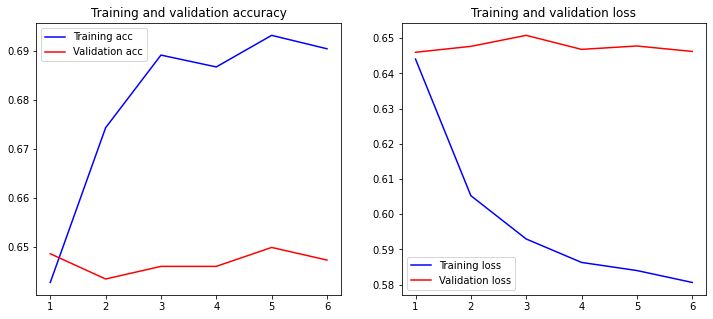

In [460]:
plot_history(history_list[0])

## claims

In [160]:
# claims
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.6502
NN macro:  0.5569
NN weighted:  0.6220
[0.6474, 0.6589, 0.6512, 0.6409, 0.6525]
[0.5503, 0.5683, 0.5662, 0.5414, 0.5582]
[0.6172, 0.6317, 0.6277, 0.6099, 0.6236]
NN roc:  0.6172


In [162]:
print(classification_report(y_category_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.4805    0.2803    0.3541       264
           1     0.6950    0.8441    0.7623       513

   micro avg     0.6525    0.6525    0.6525       777
   macro avg     0.5878    0.5622    0.5582       777
weighted avg     0.6221    0.6525    0.6236       777
 samples avg     0.6525    0.6525    0.6525       777



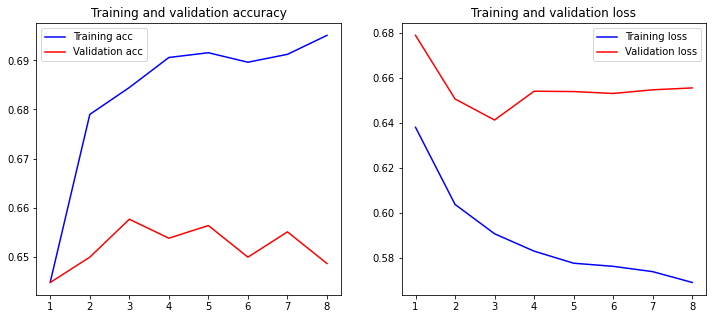

In [163]:
plot_history(history_list[0])

## text_sum

In [193]:
# train+Dense
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.6731
NN macro:  0.5724
NN weighted:  0.6389
[0.6692, 0.6834, 0.6744, 0.6654, 0.6731]
[0.5762, 0.5832, 0.572, 0.5595, 0.571]
[0.6399, 0.6487, 0.6391, 0.6287, 0.6381]
NN roc:  0.6329


In [233]:
print(classification_report(y_category_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.5130    0.2235    0.3113       264
           1     0.6903    0.8908    0.7779       513

   micro avg     0.6641    0.6641    0.6641       777
   macro avg     0.6017    0.5572    0.5446       777
weighted avg     0.6301    0.6641    0.6194       777
 samples avg     0.6641    0.6641    0.6641       777



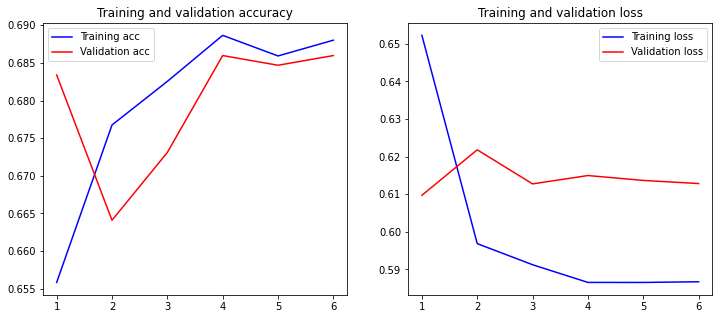

In [234]:
plot_history(history_list[0])

In [244]:
# train+BiLSTM
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.6662
NN macro:  0.5493
NN weighted:  0.6228
[0.668, 0.6705, 0.6667, 0.6615, 0.6641]
[0.5569, 0.5541, 0.5448, 0.5411, 0.5494]
[0.628, 0.6271, 0.6203, 0.6164, 0.6223]
NN roc:  0.6368


In [273]:
# 拼接+Dense
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.6510
NN macro:  0.5635
NN weighted:  0.6261
[0.6435, 0.6551, 0.6564, 0.6577, 0.6422]
[0.5566, 0.5641, 0.5676, 0.5686, 0.5605]
[0.6195, 0.6279, 0.6304, 0.6314, 0.6212]
NN roc:  0.6165


In [282]:
# 拼接+BiLSTM
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.6502
NN macro:  0.5590
NN weighted:  0.6232
[0.6486, 0.6538, 0.6499, 0.6512, 0.6474]
[0.5526, 0.5657, 0.5652, 0.5532, 0.5582]
[0.619, 0.6284, 0.6267, 0.6202, 0.6218]
NN roc:  0.6331


## node

In [414]:
# node
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.7714
NN macro:  0.7041
NN weighted:  0.7493
[0.7735, 0.7709, 0.7696, 0.7671, 0.7761]
[0.7129, 0.7087, 0.7039, 0.6831, 0.7118]
[0.7552, 0.7519, 0.7486, 0.7353, 0.7554]
NN roc:  0.8343


In [358]:
print(classification_report(y_category_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7692    0.4545    0.5714       264
           1     0.7681    0.9298    0.8413       513

   micro avg     0.7683    0.7683    0.7683       777
   macro avg     0.7687    0.6922    0.7063       777
weighted avg     0.7685    0.7683    0.7496       777
 samples avg     0.7683    0.7683    0.7683       777



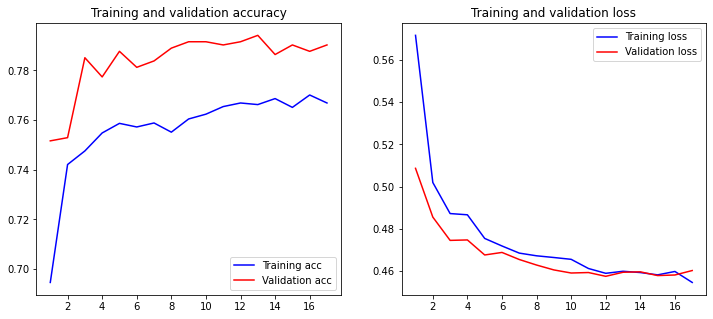

In [359]:
plot_history(history_list[0])

## node+text

In [396]:
# node+text+Dense
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))
print(roc_list)

NN acc:  0.7707
NN macro:  0.7336
NN weighted:  0.7654
[0.7709, 0.7645, 0.7735, 0.7658, 0.7786]
[0.737, 0.7293, 0.7347, 0.7263, 0.7408]
[0.7673, 0.7606, 0.7672, 0.7596, 0.7725]
NN roc:  0.8295
[0.8287627739382125, 0.8331118199539251, 0.8307785456908263, 0.8281056175793018, 0.8265697914820722]


In [333]:
print(classification_report(y_category_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7005    0.5492    0.6157       264
           1     0.7912    0.8791    0.8329       513

   micro avg     0.7671    0.7671    0.7671       777
   macro avg     0.7459    0.7142    0.7243       777
weighted avg     0.7604    0.7671    0.7591       777
 samples avg     0.7671    0.7671    0.7671       777



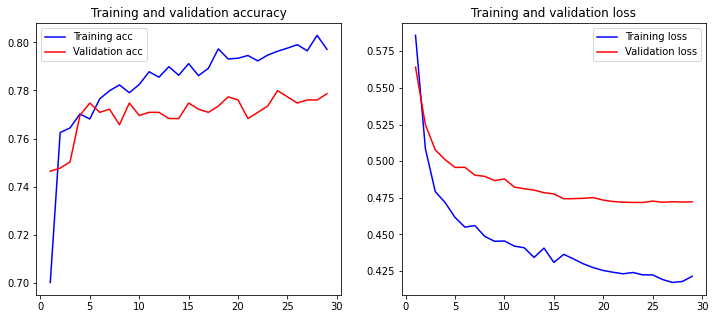

In [334]:
plot_history(history_list[0])

In [418]:
# node+text+BiLSTM
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.7696
NN macro:  0.7338
NN weighted:  0.7651
[0.7671, 0.7773, 0.7709, 0.7696, 0.7632]
[0.7334, 0.743, 0.7353, 0.7341, 0.7233]
[0.7638, 0.7731, 0.7664, 0.7652, 0.757]
NN roc:  0.8303


In [422]:
# node+text+BiLSTM
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.7704
NN macro:  0.7302
NN weighted:  0.7636
[0.7683, 0.7735, 0.7696, 0.7722, 0.7683]
[0.7305, 0.7341, 0.7293, 0.7371, 0.7199]
[0.7629, 0.7669, 0.7628, 0.7679, 0.7573]
NN roc:  0.8314


In [426]:
# node+text+BiLSTM
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.7717
NN macro:  0.7092
NN weighted:  0.7523
[0.7683, 0.7748, 0.7773, 0.7683, 0.7696]
[0.7089, 0.7123, 0.7358, 0.694, 0.6952]
[0.7511, 0.7553, 0.7694, 0.7423, 0.7435]
NN roc:  0.8347


In [430]:
# node+text+BiLSTM
metrics_arrat = np.array(metrics_list,dtype=float)
acc = np.mean(metrics_arrat[:,0])
print("NN acc:  {:.4f}".format(acc))
f1 = np.mean(metrics_arrat[:,1])
print("NN macro:  {:.4f}".format(f1))
weighted = np.mean(metrics_arrat[:,2])
print("NN weighted:  {:.4f}".format(weighted))

print(metrics_arrat[:,0].tolist())
print(metrics_arrat[:,1].tolist())
print(metrics_arrat[:,2].tolist())

roc = np.mean(roc_list)
print("NN roc:  {:.4f}".format(roc))

NN acc:  0.7709
NN macro:  0.7000
NN weighted:  0.7467
[0.7683, 0.7748, 0.7748, 0.7683, 0.7683]
[0.695, 0.7114, 0.7059, 0.699, 0.6887]
[0.7429, 0.7548, 0.7515, 0.7453, 0.7392]
NN roc:  0.8347
